https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing Libraries
import os
import copy
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [3]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [4]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


In [5]:
cdata = GetCIFAR10_TrainData(os.chdir(".."))
trainset = cdata.download_train_data()
testset = cdata.download_test_data()

VALID_RATIO = 0.9
n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
len(trainset), len(validset), len(testset)

(45000, 5000, 10000)

In [7]:
BATCH_SIZE = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# The Model - RESNET18


In [8]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [9]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.1)
        
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        # out = self.dropout1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.dropout2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        self.conv = conv3x3(in_channels=3, out_channels=64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block=block, out_channels=64, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block=block, out_channels=128, blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block=block, out_channels=256, blocks=layers[2], stride=2)
        # self.layer4 = self.make_layer(block=block, out_channels=512, blocks=layers[3], stride=2)

        self.avg_pool = nn.AvgPool2d(4)
        # self.fc = nn.Linear(256, num_classes)
        self.fc = nn.Linear(1024, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    # return ResNet(ResidualBlock, [2, 2, 2, 2])
    return ResNet(ResidualBlock, [2, 2, 2])

In [10]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    ResidualBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [11]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        # train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        # print statistics
        
        running_loss += loss.item()
        pbar.set_description(desc=f'Batch_id={batch_idx} Batch Loss={loss.item()} Running Loss={running_loss} Running Accuracy={100*correct/processed:0.2f}')
        # train_acc.append(100*correct/processed)
    
    train_losses.append(running_loss)
    train_acc.append(100*correct/processed)

In [12]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified, correct / len(test_dataloader.dataset)

In [13]:
def model_evaluation(model, device, loader):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = F.nll_loss(y_pred, y)
        
            pred = y_pred.argmax(dim=1, keepdim=True)
            acc = pred.eq(y.view_as(pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    epoch_loss / len(loader.dataset), epoch_acc, len(loader.dataset),
    100. * epoch_acc / len(loader.dataset)))

    return epoch_loss, epoch_acc / len(loader.dataset)

In [14]:
# Defining parameters

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [15]:
import pandas

def save_to_csv(csvname, train_losses, train_accs, test_losses, test_accs):
  df = pandas.DataFrame()
  df["epoch"] = [i+1 for i in range(len(train_losses))]
  df["train_loss"] = train_losses
  df["test_loss"] = test_losses
  df["train_acc"] = train_accs
  df["test_acc"] = test_accs
  df.to_csv(csvname)

In [16]:
# Training the model

train_acc = []
train_losses = []
valid_accs = []
valid_losses = []
test_acc = []
test_losses = []
min_valid_loss = None
max_acc = None

EPOCHS = 120

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)

    # Validating the model for the current epoch
    valid_loss, valid_acc = model_evaluation(model, device, validloader)  

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if not min_valid_loss:
      min_valid_loss = valid_loss
    else:
      if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model, "best_model.pickle")

    scheduler.step(train_losses[-1])
    # scheduler.step(valid_loss)

    misclassified, test_acc2 = model_testing(model, device, testloader, test_acc, test_losses)

    if not max_acc:
      max_acc = test_acc2
    else:
      if test_acc2 > max_acc:
        max_acc = test_acc2
        torch.save(model, "best_test_acc_model.pickle")

    save_to_csv("9_resnet_2_2_2_inchannels_64.csv", train_losses, train_acc, test_losses, test_acc)
  

EPOCHS : 0


Batch_id=87 Batch Loss=1.3700350522994995 Running Loss=142.80884385108948 Running Accuracy=40.35: 100%|██████████| 88/88 [00:35<00:00,  2.45it/s]



Validation set: Average loss: 0.0027, Accuracy: 2557/5000 (51.14%)


Test set: Average loss: 1.3184, Accuracy: 5207/10000 (52.07%)

EPOCHS : 1


Batch_id=87 Batch Loss=0.9870185852050781 Running Loss=102.41353684663773 Running Accuracy=57.83: 100%|██████████| 88/88 [00:38<00:00,  2.29it/s]



Validation set: Average loss: 0.0021, Accuracy: 3135/5000 (62.70%)


Test set: Average loss: 1.0260, Accuracy: 6300/10000 (63.00%)

EPOCHS : 2


Batch_id=87 Batch Loss=0.950271725654602 Running Loss=82.26363748311996 Running Accuracy=66.98: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0018, Accuracy: 3380/5000 (67.60%)


Test set: Average loss: 0.8769, Accuracy: 6935/10000 (69.35%)

EPOCHS : 3


Batch_id=87 Batch Loss=0.6662694215774536 Running Loss=71.3948346376419 Running Accuracy=71.50: 100%|██████████| 88/88 [00:38<00:00,  2.26it/s]



Validation set: Average loss: 0.0018, Accuracy: 3516/5000 (70.32%)


Test set: Average loss: 0.8782, Accuracy: 7031/10000 (70.31%)

EPOCHS : 4


Batch_id=87 Batch Loss=0.6766982674598694 Running Loss=63.905062794685364 Running Accuracy=74.47: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0016, Accuracy: 3611/5000 (72.22%)


Test set: Average loss: 0.7908, Accuracy: 7348/10000 (73.48%)

EPOCHS : 5


Batch_id=87 Batch Loss=0.7144725322723389 Running Loss=58.27175015211105 Running Accuracy=76.81: 100%|██████████| 88/88 [00:37<00:00,  2.37it/s]



Validation set: Average loss: 0.0013, Accuracy: 3839/5000 (76.78%)


Test set: Average loss: 0.6366, Accuracy: 7793/10000 (77.93%)

EPOCHS : 6


Batch_id=87 Batch Loss=0.6295957565307617 Running Loss=52.98610618710518 Running Accuracy=78.82: 100%|██████████| 88/88 [00:36<00:00,  2.39it/s]



Validation set: Average loss: 0.0013, Accuracy: 3916/5000 (78.32%)


Test set: Average loss: 0.6290, Accuracy: 7880/10000 (78.80%)

EPOCHS : 7


Batch_id=87 Batch Loss=0.5622908473014832 Running Loss=50.337855875492096 Running Accuracy=79.97: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0012, Accuracy: 4021/5000 (80.42%)


Test set: Average loss: 0.5528, Accuracy: 8119/10000 (81.19%)

EPOCHS : 8


Batch_id=87 Batch Loss=0.5015421509742737 Running Loss=47.34160390496254 Running Accuracy=81.22: 100%|██████████| 88/88 [00:38<00:00,  2.26it/s]



Validation set: Average loss: 0.0011, Accuracy: 4071/5000 (81.42%)


Test set: Average loss: 0.5171, Accuracy: 8247/10000 (82.47%)

EPOCHS : 9


Batch_id=87 Batch Loss=0.4743088483810425 Running Loss=45.135711163282394 Running Accuracy=81.94: 100%|██████████| 88/88 [00:37<00:00,  2.35it/s]



Validation set: Average loss: 0.0013, Accuracy: 3952/5000 (79.04%)


Test set: Average loss: 0.6256, Accuracy: 7911/10000 (79.11%)

EPOCHS : 10


Batch_id=87 Batch Loss=0.46113237738609314 Running Loss=41.859487891197205 Running Accuracy=83.42: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0010, Accuracy: 4159/5000 (83.18%)


Test set: Average loss: 0.4865, Accuracy: 8372/10000 (83.72%)

EPOCHS : 11


Batch_id=87 Batch Loss=0.5025734305381775 Running Loss=39.85951009392738 Running Accuracy=84.32: 100%|██████████| 88/88 [00:37<00:00,  2.38it/s]



Validation set: Average loss: 0.0013, Accuracy: 3922/5000 (78.44%)


Test set: Average loss: 0.6272, Accuracy: 7911/10000 (79.11%)

EPOCHS : 12


Batch_id=87 Batch Loss=0.4450671672821045 Running Loss=37.844900608062744 Running Accuracy=84.94: 100%|██████████| 88/88 [00:37<00:00,  2.37it/s]



Validation set: Average loss: 0.0010, Accuracy: 4160/5000 (83.20%)


Test set: Average loss: 0.5076, Accuracy: 8341/10000 (83.41%)

EPOCHS : 13


Batch_id=87 Batch Loss=0.3655441403388977 Running Loss=35.790935069322586 Running Accuracy=85.94: 100%|██████████| 88/88 [00:38<00:00,  2.26it/s]



Validation set: Average loss: 0.0009, Accuracy: 4233/5000 (84.66%)


Test set: Average loss: 0.4623, Accuracy: 8453/10000 (84.53%)

EPOCHS : 14


Batch_id=87 Batch Loss=0.4594862163066864 Running Loss=34.88301593065262 Running Accuracy=86.12: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0012, Accuracy: 4049/5000 (80.98%)


Test set: Average loss: 0.5990, Accuracy: 8095/10000 (80.95%)

EPOCHS : 15


Batch_id=87 Batch Loss=0.3930264413356781 Running Loss=33.806387811899185 Running Accuracy=86.63: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0010, Accuracy: 4196/5000 (83.92%)


Test set: Average loss: 0.4779, Accuracy: 8404/10000 (84.04%)

EPOCHS : 16


Batch_id=87 Batch Loss=0.3403630554676056 Running Loss=31.200519114732742 Running Accuracy=87.45: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s]



Validation set: Average loss: 0.0009, Accuracy: 4225/5000 (84.50%)


Test set: Average loss: 0.4748, Accuracy: 8402/10000 (84.02%)

EPOCHS : 17


Batch_id=87 Batch Loss=0.29257023334503174 Running Loss=30.437849313020706 Running Accuracy=87.90: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0011, Accuracy: 4118/5000 (82.36%)


Test set: Average loss: 0.5203, Accuracy: 8321/10000 (83.21%)

EPOCHS : 18


Batch_id=87 Batch Loss=0.3303871750831604 Running Loss=29.197197645902634 Running Accuracy=88.37: 100%|██████████| 88/88 [00:38<00:00,  2.31it/s]



Validation set: Average loss: 0.0010, Accuracy: 4175/5000 (83.50%)


Test set: Average loss: 0.4773, Accuracy: 8432/10000 (84.32%)

EPOCHS : 19


Batch_id=87 Batch Loss=0.29099419713020325 Running Loss=28.5127155482769 Running Accuracy=88.73: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0011, Accuracy: 4130/5000 (82.60%)


Test set: Average loss: 0.5345, Accuracy: 8322/10000 (83.22%)

EPOCHS : 20


Batch_id=87 Batch Loss=0.27984264492988586 Running Loss=27.191461876034737 Running Accuracy=89.17: 100%|██████████| 88/88 [00:37<00:00,  2.35it/s]



Validation set: Average loss: 0.0008, Accuracy: 4290/5000 (85.80%)


Test set: Average loss: 0.4272, Accuracy: 8604/10000 (86.04%)

EPOCHS : 21


Batch_id=87 Batch Loss=0.37802988290786743 Running Loss=26.218340411782265 Running Accuracy=89.51: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0009, Accuracy: 4260/5000 (85.20%)


Test set: Average loss: 0.4229, Accuracy: 8630/10000 (86.30%)

EPOCHS : 22


Batch_id=87 Batch Loss=0.28857725858688354 Running Loss=25.01831927895546 Running Accuracy=89.85: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0008, Accuracy: 4323/5000 (86.46%)


Test set: Average loss: 0.4312, Accuracy: 8624/10000 (86.24%)

EPOCHS : 23


Batch_id=87 Batch Loss=0.2714390754699707 Running Loss=24.421127185225487 Running Accuracy=90.03: 100%|██████████| 88/88 [00:38<00:00,  2.28it/s]



Validation set: Average loss: 0.0008, Accuracy: 4342/5000 (86.84%)


Test set: Average loss: 0.4025, Accuracy: 8721/10000 (87.21%)

EPOCHS : 24


Batch_id=87 Batch Loss=0.2839818000793457 Running Loss=24.296620026230812 Running Accuracy=90.26: 100%|██████████| 88/88 [00:36<00:00,  2.39it/s]



Validation set: Average loss: 0.0008, Accuracy: 4312/5000 (86.24%)


Test set: Average loss: 0.4085, Accuracy: 8644/10000 (86.44%)

EPOCHS : 25


Batch_id=87 Batch Loss=0.3204561769962311 Running Loss=23.464241206645966 Running Accuracy=90.65: 100%|██████████| 88/88 [00:38<00:00,  2.30it/s]



Validation set: Average loss: 0.0009, Accuracy: 4295/5000 (85.90%)


Test set: Average loss: 0.4130, Accuracy: 8677/10000 (86.77%)

EPOCHS : 26


Batch_id=87 Batch Loss=0.2640599310398102 Running Loss=21.940065041184425 Running Accuracy=91.33: 100%|██████████| 88/88 [00:38<00:00,  2.30it/s]



Validation set: Average loss: 0.0008, Accuracy: 4324/5000 (86.48%)


Test set: Average loss: 0.4087, Accuracy: 8714/10000 (87.14%)

EPOCHS : 27


Batch_id=87 Batch Loss=0.20344102382659912 Running Loss=21.080412939190865 Running Accuracy=91.52: 100%|██████████| 88/88 [00:39<00:00,  2.24it/s]



Validation set: Average loss: 0.0009, Accuracy: 4279/5000 (85.58%)


Test set: Average loss: 0.4684, Accuracy: 8607/10000 (86.07%)

EPOCHS : 28


Batch_id=87 Batch Loss=0.24511228501796722 Running Loss=21.06234447658062 Running Accuracy=91.48: 100%|██████████| 88/88 [00:38<00:00,  2.30it/s]



Validation set: Average loss: 0.0008, Accuracy: 4364/5000 (87.28%)


Test set: Average loss: 0.4064, Accuracy: 8718/10000 (87.18%)

EPOCHS : 29


Batch_id=87 Batch Loss=0.2372945249080658 Running Loss=20.219393745064735 Running Accuracy=91.84: 100%|██████████| 88/88 [00:38<00:00,  2.30it/s]



Validation set: Average loss: 0.0008, Accuracy: 4361/5000 (87.22%)


Test set: Average loss: 0.4078, Accuracy: 8741/10000 (87.41%)

EPOCHS : 30


Batch_id=87 Batch Loss=0.23117423057556152 Running Loss=18.920374378561974 Running Accuracy=92.38: 100%|██████████| 88/88 [00:36<00:00,  2.40it/s]



Validation set: Average loss: 0.0009, Accuracy: 4293/5000 (85.86%)


Test set: Average loss: 0.4774, Accuracy: 8598/10000 (85.98%)

EPOCHS : 31


Batch_id=87 Batch Loss=0.19353118538856506 Running Loss=18.18788269162178 Running Accuracy=92.74: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0008, Accuracy: 4383/5000 (87.66%)


Test set: Average loss: 0.4007, Accuracy: 8724/10000 (87.24%)

EPOCHS : 32


Batch_id=87 Batch Loss=0.19379167258739471 Running Loss=17.733213365077972 Running Accuracy=92.87: 100%|██████████| 88/88 [00:39<00:00,  2.24it/s]



Validation set: Average loss: 0.0008, Accuracy: 4409/5000 (88.18%)


Test set: Average loss: 0.3964, Accuracy: 8774/10000 (87.74%)

EPOCHS : 33


Batch_id=87 Batch Loss=0.2063794732093811 Running Loss=17.462573170661926 Running Accuracy=92.98: 100%|██████████| 88/88 [00:38<00:00,  2.29it/s]



Validation set: Average loss: 0.0009, Accuracy: 4327/5000 (86.54%)


Test set: Average loss: 0.4649, Accuracy: 8600/10000 (86.00%)

EPOCHS : 34


Batch_id=87 Batch Loss=0.22086037695407867 Running Loss=16.97115235030651 Running Accuracy=93.13: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0008, Accuracy: 4385/5000 (87.70%)


Test set: Average loss: 0.4182, Accuracy: 8715/10000 (87.15%)

EPOCHS : 35


Batch_id=87 Batch Loss=0.21068967878818512 Running Loss=16.665044993162155 Running Accuracy=93.34: 100%|██████████| 88/88 [00:38<00:00,  2.27it/s]



Validation set: Average loss: 0.0009, Accuracy: 4361/5000 (87.22%)


Test set: Average loss: 0.4301, Accuracy: 8743/10000 (87.43%)

EPOCHS : 36


Batch_id=87 Batch Loss=0.16265878081321716 Running Loss=15.465861305594444 Running Accuracy=93.78: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0008, Accuracy: 4431/5000 (88.62%)


Test set: Average loss: 0.3931, Accuracy: 8821/10000 (88.21%)

EPOCHS : 37


Batch_id=87 Batch Loss=0.18382085859775543 Running Loss=15.765758894383907 Running Accuracy=93.70: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0009, Accuracy: 4308/5000 (86.16%)


Test set: Average loss: 0.4757, Accuracy: 8589/10000 (85.89%)

EPOCHS : 38


Batch_id=87 Batch Loss=0.1863168478012085 Running Loss=14.787983365356922 Running Accuracy=94.13: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0008, Accuracy: 4404/5000 (88.08%)


Test set: Average loss: 0.3854, Accuracy: 8815/10000 (88.15%)

EPOCHS : 39


Batch_id=87 Batch Loss=0.1673453450202942 Running Loss=14.53375093638897 Running Accuracy=94.14: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s]



Validation set: Average loss: 0.0009, Accuracy: 4337/5000 (86.74%)


Test set: Average loss: 0.4618, Accuracy: 8679/10000 (86.79%)

EPOCHS : 40


Batch_id=87 Batch Loss=0.21260720491409302 Running Loss=13.678135119378567 Running Accuracy=94.45: 100%|██████████| 88/88 [00:37<00:00,  2.37it/s]



Validation set: Average loss: 0.0009, Accuracy: 4314/5000 (86.28%)


Test set: Average loss: 0.4622, Accuracy: 8674/10000 (86.74%)

EPOCHS : 41


Batch_id=87 Batch Loss=0.14290741086006165 Running Loss=13.854275770485401 Running Accuracy=94.39: 100%|██████████| 88/88 [00:36<00:00,  2.39it/s]



Validation set: Average loss: 0.0008, Accuracy: 4379/5000 (87.58%)


Test set: Average loss: 0.4273, Accuracy: 8759/10000 (87.59%)

EPOCHS : 42


Batch_id=87 Batch Loss=0.15276044607162476 Running Loss=13.321062333881855 Running Accuracy=94.70: 100%|██████████| 88/88 [00:38<00:00,  2.26it/s]



Validation set: Average loss: 0.0008, Accuracy: 4407/5000 (88.14%)


Test set: Average loss: 0.4220, Accuracy: 8769/10000 (87.69%)

EPOCHS : 43


Batch_id=87 Batch Loss=0.1706351935863495 Running Loss=12.915097519755363 Running Accuracy=94.84: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0009, Accuracy: 4386/5000 (87.72%)


Test set: Average loss: 0.4412, Accuracy: 8742/10000 (87.42%)

EPOCHS : 44


Batch_id=87 Batch Loss=0.1645675152540207 Running Loss=12.04229125380516 Running Accuracy=95.11: 100%|██████████| 88/88 [00:38<00:00,  2.27it/s]



Validation set: Average loss: 0.0009, Accuracy: 4400/5000 (88.00%)


Test set: Average loss: 0.4201, Accuracy: 8820/10000 (88.20%)

EPOCHS : 45


Batch_id=87 Batch Loss=0.16711753606796265 Running Loss=12.316711112856865 Running Accuracy=95.05: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0008, Accuracy: 4401/5000 (88.02%)


Test set: Average loss: 0.4041, Accuracy: 8849/10000 (88.49%)

EPOCHS : 46


Batch_id=87 Batch Loss=0.1371605098247528 Running Loss=11.377396181225777 Running Accuracy=95.48: 100%|██████████| 88/88 [00:37<00:00,  2.36it/s]



Validation set: Average loss: 0.0007, Accuracy: 4466/5000 (89.32%)


Test set: Average loss: 0.3675, Accuracy: 8923/10000 (89.23%)

EPOCHS : 47


Batch_id=87 Batch Loss=0.12034260481595993 Running Loss=12.045526996254921 Running Accuracy=95.21: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s]



Validation set: Average loss: 0.0008, Accuracy: 4429/5000 (88.58%)


Test set: Average loss: 0.4118, Accuracy: 8819/10000 (88.19%)

EPOCHS : 48


Batch_id=87 Batch Loss=0.1394987404346466 Running Loss=10.93754506856203 Running Accuracy=95.68: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0007, Accuracy: 4438/5000 (88.76%)


Test set: Average loss: 0.3760, Accuracy: 8917/10000 (89.17%)

EPOCHS : 49


Batch_id=87 Batch Loss=0.1300889104604721 Running Loss=11.003946527838707 Running Accuracy=95.65: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0008, Accuracy: 4461/5000 (89.22%)


Test set: Average loss: 0.3753, Accuracy: 8923/10000 (89.23%)

EPOCHS : 50


Batch_id=87 Batch Loss=0.10399258136749268 Running Loss=10.73470152914524 Running Accuracy=95.60: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0008, Accuracy: 4432/5000 (88.64%)


Test set: Average loss: 0.3941, Accuracy: 8887/10000 (88.87%)

EPOCHS : 51


Batch_id=87 Batch Loss=0.08205319195985794 Running Loss=10.219572968780994 Running Accuracy=95.92: 100%|██████████| 88/88 [00:37<00:00,  2.36it/s]



Validation set: Average loss: 0.0008, Accuracy: 4399/5000 (87.98%)


Test set: Average loss: 0.4249, Accuracy: 8772/10000 (87.72%)

EPOCHS : 52


Batch_id=87 Batch Loss=0.13264763355255127 Running Loss=10.058917507529259 Running Accuracy=96.06: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0007, Accuracy: 4469/5000 (89.38%)


Test set: Average loss: 0.3665, Accuracy: 8948/10000 (89.48%)

EPOCHS : 53


Batch_id=87 Batch Loss=0.13807076215744019 Running Loss=9.999112337827682 Running Accuracy=95.91: 100%|██████████| 88/88 [00:37<00:00,  2.35it/s]



Validation set: Average loss: 0.0009, Accuracy: 4380/5000 (87.60%)


Test set: Average loss: 0.4547, Accuracy: 8789/10000 (87.89%)

EPOCHS : 54


Batch_id=87 Batch Loss=0.10386306047439575 Running Loss=9.711436167359352 Running Accuracy=96.26: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s]



Validation set: Average loss: 0.0008, Accuracy: 4454/5000 (89.08%)


Test set: Average loss: 0.3835, Accuracy: 8920/10000 (89.20%)

EPOCHS : 55


Batch_id=87 Batch Loss=0.08968468010425568 Running Loss=9.329402089118958 Running Accuracy=96.19: 100%|██████████| 88/88 [00:37<00:00,  2.35it/s]



Validation set: Average loss: 0.0008, Accuracy: 4424/5000 (88.48%)


Test set: Average loss: 0.4012, Accuracy: 8905/10000 (89.05%)

EPOCHS : 56


Batch_id=87 Batch Loss=0.07136350870132446 Running Loss=8.709704600274563 Running Accuracy=96.45: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0008, Accuracy: 4476/5000 (89.52%)


Test set: Average loss: 0.3969, Accuracy: 8905/10000 (89.05%)

EPOCHS : 57


Batch_id=87 Batch Loss=0.11529067158699036 Running Loss=8.716946929693222 Running Accuracy=96.46: 100%|██████████| 88/88 [00:38<00:00,  2.28it/s]



Validation set: Average loss: 0.0008, Accuracy: 4471/5000 (89.42%)


Test set: Average loss: 0.3956, Accuracy: 8904/10000 (89.04%)

EPOCHS : 58


Batch_id=87 Batch Loss=0.12529610097408295 Running Loss=8.33097655326128 Running Accuracy=96.71: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s]



Validation set: Average loss: 0.0008, Accuracy: 4481/5000 (89.62%)


Test set: Average loss: 0.3731, Accuracy: 8962/10000 (89.62%)

EPOCHS : 59


Batch_id=87 Batch Loss=0.12079057097434998 Running Loss=8.417611997574568 Running Accuracy=96.59: 100%|██████████| 88/88 [00:38<00:00,  2.30it/s]



Validation set: Average loss: 0.0009, Accuracy: 4406/5000 (88.12%)


Test set: Average loss: 0.4410, Accuracy: 8849/10000 (88.49%)

EPOCHS : 60


Batch_id=87 Batch Loss=0.07246547192335129 Running Loss=7.87898538261652 Running Accuracy=96.82: 100%|██████████| 88/88 [00:36<00:00,  2.39it/s]



Validation set: Average loss: 0.0008, Accuracy: 4456/5000 (89.12%)


Test set: Average loss: 0.4043, Accuracy: 8893/10000 (88.93%)

EPOCHS : 61


Batch_id=87 Batch Loss=0.10682042688131332 Running Loss=7.683021996170282 Running Accuracy=96.90: 100%|██████████| 88/88 [00:37<00:00,  2.37it/s]



Validation set: Average loss: 0.0008, Accuracy: 4480/5000 (89.60%)


Test set: Average loss: 0.3793, Accuracy: 8953/10000 (89.53%)

EPOCHS : 62


Batch_id=87 Batch Loss=0.09441082924604416 Running Loss=7.58298597112298 Running Accuracy=97.05: 100%|██████████| 88/88 [00:39<00:00,  2.26it/s]



Validation set: Average loss: 0.0008, Accuracy: 4464/5000 (89.28%)


Test set: Average loss: 0.4198, Accuracy: 8897/10000 (88.97%)

EPOCHS : 63


Batch_id=87 Batch Loss=0.0879184827208519 Running Loss=7.410453964024782 Running Accuracy=97.08: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0008, Accuracy: 4469/5000 (89.38%)


Test set: Average loss: 0.3892, Accuracy: 8956/10000 (89.56%)

EPOCHS : 64


Batch_id=87 Batch Loss=0.07817068696022034 Running Loss=7.76490043848753 Running Accuracy=96.91: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0009, Accuracy: 4430/5000 (88.60%)


Test set: Average loss: 0.4619, Accuracy: 8830/10000 (88.30%)

EPOCHS : 65


Batch_id=87 Batch Loss=0.07610750943422318 Running Loss=7.221429985016584 Running Accuracy=97.14: 100%|██████████| 88/88 [00:38<00:00,  2.30it/s]



Validation set: Average loss: 0.0007, Accuracy: 4481/5000 (89.62%)


Test set: Average loss: 0.3578, Accuracy: 9025/10000 (90.25%)

EPOCHS : 66


Batch_id=87 Batch Loss=0.15089334547519684 Running Loss=7.108788471668959 Running Accuracy=97.14: 100%|██████████| 88/88 [00:37<00:00,  2.36it/s]



Validation set: Average loss: 0.0008, Accuracy: 4455/5000 (89.10%)


Test set: Average loss: 0.4071, Accuracy: 8935/10000 (89.35%)

EPOCHS : 67


Batch_id=87 Batch Loss=0.06311705708503723 Running Loss=6.620337583124638 Running Accuracy=97.36: 100%|██████████| 88/88 [00:38<00:00,  2.30it/s]



Validation set: Average loss: 0.0007, Accuracy: 4485/5000 (89.70%)


Test set: Average loss: 0.3945, Accuracy: 8945/10000 (89.45%)

EPOCHS : 68


Batch_id=87 Batch Loss=0.06258411705493927 Running Loss=6.13424614071846 Running Accuracy=97.57: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0007, Accuracy: 4509/5000 (90.18%)


Test set: Average loss: 0.3668, Accuracy: 9013/10000 (90.13%)

EPOCHS : 69


Batch_id=87 Batch Loss=0.049436889588832855 Running Loss=6.353303387761116 Running Accuracy=97.50: 100%|██████████| 88/88 [00:38<00:00,  2.29it/s]



Validation set: Average loss: 0.0008, Accuracy: 4488/5000 (89.76%)


Test set: Average loss: 0.4131, Accuracy: 8972/10000 (89.72%)

EPOCHS : 70


Batch_id=87 Batch Loss=0.09053268283605576 Running Loss=6.303316444158554 Running Accuracy=97.50: 100%|██████████| 88/88 [00:38<00:00,  2.31it/s]



Validation set: Average loss: 0.0008, Accuracy: 4450/5000 (89.00%)


Test set: Average loss: 0.4348, Accuracy: 8912/10000 (89.12%)

EPOCHS : 71


Batch_id=87 Batch Loss=0.059870168566703796 Running Loss=6.211975663900375 Running Accuracy=97.55: 100%|██████████| 88/88 [00:37<00:00,  2.37it/s]



Validation set: Average loss: 0.0008, Accuracy: 4463/5000 (89.26%)

Epoch 00072: reducing learning rate of group 0 to 1.0000e-03.

Test set: Average loss: 0.4095, Accuracy: 8958/10000 (89.58%)

EPOCHS : 72


Batch_id=87 Batch Loss=0.056440066546201706 Running Loss=4.401388477534056 Running Accuracy=98.31: 100%|██████████| 88/88 [00:40<00:00,  2.19it/s]



Validation set: Average loss: 0.0006, Accuracy: 4580/5000 (91.60%)


Test set: Average loss: 0.3131, Accuracy: 9158/10000 (91.58%)

EPOCHS : 73


Batch_id=87 Batch Loss=0.033252641558647156 Running Loss=3.4138150457292795 Running Accuracy=98.79: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s]



Validation set: Average loss: 0.0006, Accuracy: 4576/5000 (91.52%)


Test set: Average loss: 0.3112, Accuracy: 9165/10000 (91.65%)

EPOCHS : 74


Batch_id=87 Batch Loss=0.0383010059595108 Running Loss=2.9523888314142823 Running Accuracy=99.05: 100%|██████████| 88/88 [00:38<00:00,  2.29it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.3109, Accuracy: 9177/10000 (91.77%)

EPOCHS : 75


Batch_id=87 Batch Loss=0.045424334704875946 Running Loss=2.9335634987801313 Running Accuracy=99.04: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0006, Accuracy: 4587/5000 (91.74%)


Test set: Average loss: 0.3100, Accuracy: 9178/10000 (91.78%)

EPOCHS : 76


Batch_id=87 Batch Loss=0.030471039935946465 Running Loss=2.7784674568101764 Running Accuracy=99.12: 100%|██████████| 88/88 [00:38<00:00,  2.31it/s]



Validation set: Average loss: 0.0006, Accuracy: 4587/5000 (91.74%)


Test set: Average loss: 0.3101, Accuracy: 9165/10000 (91.65%)

EPOCHS : 77


Batch_id=87 Batch Loss=0.04004392400383949 Running Loss=2.6589160077273846 Running Accuracy=99.12: 100%|██████████| 88/88 [00:38<00:00,  2.30it/s]



Validation set: Average loss: 0.0006, Accuracy: 4593/5000 (91.86%)


Test set: Average loss: 0.3093, Accuracy: 9163/10000 (91.63%)

EPOCHS : 78


Batch_id=87 Batch Loss=0.023576775565743446 Running Loss=2.561784088611603 Running Accuracy=99.17: 100%|██████████| 88/88 [00:36<00:00,  2.38it/s]



Validation set: Average loss: 0.0006, Accuracy: 4594/5000 (91.88%)


Test set: Average loss: 0.3090, Accuracy: 9185/10000 (91.85%)

EPOCHS : 79


Batch_id=87 Batch Loss=0.035717837512493134 Running Loss=2.5188288437202573 Running Accuracy=99.18: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0006, Accuracy: 4587/5000 (91.74%)


Test set: Average loss: 0.3116, Accuracy: 9177/10000 (91.77%)

EPOCHS : 80


Batch_id=87 Batch Loss=0.017039304599165916 Running Loss=2.5584083683788776 Running Accuracy=99.15: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0006, Accuracy: 4582/5000 (91.64%)


Test set: Average loss: 0.3061, Accuracy: 9194/10000 (91.94%)

EPOCHS : 81


Batch_id=87 Batch Loss=0.029213922098279 Running Loss=2.43502008728683 Running Accuracy=99.19: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s]



Validation set: Average loss: 0.0006, Accuracy: 4597/5000 (91.94%)


Test set: Average loss: 0.3061, Accuracy: 9195/10000 (91.95%)

EPOCHS : 82


Batch_id=87 Batch Loss=0.03301810845732689 Running Loss=2.341465385630727 Running Accuracy=99.28: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0006, Accuracy: 4595/5000 (91.90%)


Test set: Average loss: 0.3102, Accuracy: 9185/10000 (91.85%)

EPOCHS : 83


Batch_id=87 Batch Loss=0.025021445006132126 Running Loss=2.3680091397836804 Running Accuracy=99.27: 100%|██████████| 88/88 [00:36<00:00,  2.38it/s]



Validation set: Average loss: 0.0006, Accuracy: 4596/5000 (91.92%)


Test set: Average loss: 0.3092, Accuracy: 9182/10000 (91.82%)

EPOCHS : 84


Batch_id=87 Batch Loss=0.019168870523571968 Running Loss=2.344503498636186 Running Accuracy=99.31: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0006, Accuracy: 4585/5000 (91.70%)


Test set: Average loss: 0.3099, Accuracy: 9193/10000 (91.93%)

EPOCHS : 85


Batch_id=87 Batch Loss=0.017042987048625946 Running Loss=2.3098886972293258 Running Accuracy=99.27: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s]



Validation set: Average loss: 0.0006, Accuracy: 4598/5000 (91.96%)


Test set: Average loss: 0.3112, Accuracy: 9197/10000 (91.97%)

EPOCHS : 86


Batch_id=87 Batch Loss=0.03183664008975029 Running Loss=2.2141615888103843 Running Accuracy=99.35: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s]



Validation set: Average loss: 0.0006, Accuracy: 4590/5000 (91.80%)


Test set: Average loss: 0.3120, Accuracy: 9183/10000 (91.83%)

EPOCHS : 87


Batch_id=87 Batch Loss=0.020431499928236008 Running Loss=2.230724222958088 Running Accuracy=99.31: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0006, Accuracy: 4584/5000 (91.68%)


Test set: Average loss: 0.3090, Accuracy: 9192/10000 (91.92%)

EPOCHS : 88


Batch_id=87 Batch Loss=0.052854642271995544 Running Loss=2.267234353348613 Running Accuracy=99.30: 100%|██████████| 88/88 [00:37<00:00,  2.38it/s]



Validation set: Average loss: 0.0006, Accuracy: 4587/5000 (91.74%)


Test set: Average loss: 0.3099, Accuracy: 9188/10000 (91.88%)

EPOCHS : 89


Batch_id=87 Batch Loss=0.033698275685310364 Running Loss=2.194830307736993 Running Accuracy=99.34: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0006, Accuracy: 4590/5000 (91.80%)


Test set: Average loss: 0.3118, Accuracy: 9185/10000 (91.85%)

EPOCHS : 90


Batch_id=87 Batch Loss=0.020467763766646385 Running Loss=2.1125418981537223 Running Accuracy=99.41: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0006, Accuracy: 4592/5000 (91.84%)


Test set: Average loss: 0.3080, Accuracy: 9182/10000 (91.82%)

EPOCHS : 91


Batch_id=87 Batch Loss=0.010571055114269257 Running Loss=2.1560547091066837 Running Accuracy=99.34: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0006, Accuracy: 4592/5000 (91.84%)


Test set: Average loss: 0.3131, Accuracy: 9190/10000 (91.90%)

EPOCHS : 92


Batch_id=87 Batch Loss=0.02445848658680916 Running Loss=2.067247813567519 Running Accuracy=99.38: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0006, Accuracy: 4599/5000 (91.98%)


Test set: Average loss: 0.3136, Accuracy: 9190/10000 (91.90%)

EPOCHS : 93


Batch_id=87 Batch Loss=0.022858619689941406 Running Loss=2.162474723532796 Running Accuracy=99.31: 100%|██████████| 88/88 [00:36<00:00,  2.39it/s]



Validation set: Average loss: 0.0006, Accuracy: 4596/5000 (91.92%)


Test set: Average loss: 0.3120, Accuracy: 9185/10000 (91.85%)

EPOCHS : 94


Batch_id=87 Batch Loss=0.02097460813820362 Running Loss=2.0002207858487964 Running Accuracy=99.42: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0006, Accuracy: 4598/5000 (91.96%)


Test set: Average loss: 0.3143, Accuracy: 9186/10000 (91.86%)

EPOCHS : 95


Batch_id=87 Batch Loss=0.01545597892254591 Running Loss=2.160781489685178 Running Accuracy=99.28: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0006, Accuracy: 4593/5000 (91.86%)


Test set: Average loss: 0.3129, Accuracy: 9196/10000 (91.96%)

EPOCHS : 96


Batch_id=87 Batch Loss=0.019002366811037064 Running Loss=1.9913042793050408 Running Accuracy=99.40: 100%|██████████| 88/88 [00:37<00:00,  2.35it/s]



Validation set: Average loss: 0.0006, Accuracy: 4598/5000 (91.96%)


Test set: Average loss: 0.3128, Accuracy: 9179/10000 (91.79%)

EPOCHS : 97


Batch_id=87 Batch Loss=0.02053362876176834 Running Loss=2.0671048164367676 Running Accuracy=99.36: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0006, Accuracy: 4595/5000 (91.90%)


Test set: Average loss: 0.3135, Accuracy: 9196/10000 (91.96%)

EPOCHS : 98


Batch_id=87 Batch Loss=0.028578724712133408 Running Loss=1.9305143523961306 Running Accuracy=99.42: 100%|██████████| 88/88 [00:37<00:00,  2.38it/s]



Validation set: Average loss: 0.0006, Accuracy: 4587/5000 (91.74%)


Test set: Average loss: 0.3182, Accuracy: 9178/10000 (91.78%)

EPOCHS : 99


Batch_id=87 Batch Loss=0.019984111189842224 Running Loss=1.9526029815897346 Running Accuracy=99.38: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0006, Accuracy: 4589/5000 (91.78%)


Test set: Average loss: 0.3154, Accuracy: 9188/10000 (91.88%)

EPOCHS : 100


Batch_id=87 Batch Loss=0.01791257970035076 Running Loss=1.8483393620699644 Running Accuracy=99.46: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s]



Validation set: Average loss: 0.0006, Accuracy: 4591/5000 (91.82%)


Test set: Average loss: 0.3120, Accuracy: 9203/10000 (92.03%)

EPOCHS : 101


Batch_id=87 Batch Loss=0.034859560430049896 Running Loss=1.9279806418344378 Running Accuracy=99.41: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0006, Accuracy: 4592/5000 (91.84%)


Test set: Average loss: 0.3136, Accuracy: 9183/10000 (91.83%)

EPOCHS : 102


Batch_id=87 Batch Loss=0.01551729068160057 Running Loss=1.8993020569905639 Running Accuracy=99.44: 100%|██████████| 88/88 [00:37<00:00,  2.35it/s]



Validation set: Average loss: 0.0006, Accuracy: 4585/5000 (91.70%)


Test set: Average loss: 0.3164, Accuracy: 9187/10000 (91.87%)

EPOCHS : 103


Batch_id=87 Batch Loss=0.01601850427687168 Running Loss=1.9021049747243524 Running Accuracy=99.40: 100%|██████████| 88/88 [00:37<00:00,  2.37it/s]



Validation set: Average loss: 0.0006, Accuracy: 4594/5000 (91.88%)

Epoch 00104: reducing learning rate of group 0 to 1.0000e-04.

Test set: Average loss: 0.3208, Accuracy: 9180/10000 (91.80%)

EPOCHS : 104


Batch_id=87 Batch Loss=0.01982387900352478 Running Loss=1.8686895538121462 Running Accuracy=99.44: 100%|██████████| 88/88 [00:37<00:00,  2.35it/s]



Validation set: Average loss: 0.0006, Accuracy: 4589/5000 (91.78%)


Test set: Average loss: 0.3147, Accuracy: 9197/10000 (91.97%)

EPOCHS : 105


Batch_id=87 Batch Loss=0.02030142769217491 Running Loss=1.8457522690296173 Running Accuracy=99.45: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0006, Accuracy: 4595/5000 (91.90%)


Test set: Average loss: 0.3156, Accuracy: 9189/10000 (91.89%)

EPOCHS : 106


Batch_id=87 Batch Loss=0.014939156360924244 Running Loss=1.769125634804368 Running Accuracy=99.54: 100%|██████████| 88/88 [00:37<00:00,  2.36it/s]



Validation set: Average loss: 0.0006, Accuracy: 4593/5000 (91.86%)


Test set: Average loss: 0.3148, Accuracy: 9186/10000 (91.86%)

EPOCHS : 107


Batch_id=87 Batch Loss=0.02197127975523472 Running Loss=1.8248330987989902 Running Accuracy=99.42: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0006, Accuracy: 4593/5000 (91.86%)


Test set: Average loss: 0.3147, Accuracy: 9195/10000 (91.95%)

EPOCHS : 108


Batch_id=87 Batch Loss=0.013959513045847416 Running Loss=1.6771220620721579 Running Accuracy=99.54: 100%|██████████| 88/88 [00:37<00:00,  2.32it/s]



Validation set: Average loss: 0.0006, Accuracy: 4590/5000 (91.80%)


Test set: Average loss: 0.3140, Accuracy: 9192/10000 (91.92%)

EPOCHS : 109


Batch_id=87 Batch Loss=0.021605847403407097 Running Loss=1.783116809092462 Running Accuracy=99.49: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0006, Accuracy: 4595/5000 (91.90%)


Test set: Average loss: 0.3159, Accuracy: 9188/10000 (91.88%)

EPOCHS : 110


Batch_id=87 Batch Loss=0.018254093825817108 Running Loss=1.882328082807362 Running Accuracy=99.41: 100%|██████████| 88/88 [00:38<00:00,  2.32it/s]



Validation set: Average loss: 0.0006, Accuracy: 4596/5000 (91.92%)


Test set: Average loss: 0.3137, Accuracy: 9189/10000 (91.89%)

EPOCHS : 111


Batch_id=87 Batch Loss=0.03365548700094223 Running Loss=1.8241520747542381 Running Accuracy=99.46: 100%|██████████| 88/88 [00:36<00:00,  2.38it/s]



Validation set: Average loss: 0.0006, Accuracy: 4601/5000 (92.02%)

Epoch 00112: reducing learning rate of group 0 to 1.0000e-05.

Test set: Average loss: 0.3129, Accuracy: 9191/10000 (91.91%)

EPOCHS : 112


Batch_id=87 Batch Loss=0.016765350475907326 Running Loss=1.7694796361029148 Running Accuracy=99.46: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s]



Validation set: Average loss: 0.0006, Accuracy: 4600/5000 (92.00%)


Test set: Average loss: 0.3128, Accuracy: 9195/10000 (91.95%)

EPOCHS : 113


Batch_id=87 Batch Loss=0.028173470869660378 Running Loss=1.8198554506525397 Running Accuracy=99.48: 100%|██████████| 88/88 [00:38<00:00,  2.31it/s]



Validation set: Average loss: 0.0006, Accuracy: 4600/5000 (92.00%)


Test set: Average loss: 0.3143, Accuracy: 9192/10000 (91.92%)

EPOCHS : 114


Batch_id=87 Batch Loss=0.030673280358314514 Running Loss=1.813309500925243 Running Accuracy=99.43: 100%|██████████| 88/88 [00:37<00:00,  2.36it/s]



Validation set: Average loss: 0.0006, Accuracy: 4600/5000 (92.00%)

Epoch 00115: reducing learning rate of group 0 to 1.0000e-06.

Test set: Average loss: 0.3134, Accuracy: 9189/10000 (91.89%)

EPOCHS : 115


Batch_id=87 Batch Loss=0.012123077176511288 Running Loss=1.6976667745038867 Running Accuracy=99.54: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s]



Validation set: Average loss: 0.0006, Accuracy: 4598/5000 (91.96%)


Test set: Average loss: 0.3136, Accuracy: 9189/10000 (91.89%)

EPOCHS : 116


Batch_id=87 Batch Loss=0.025487452745437622 Running Loss=1.8055365718901157 Running Accuracy=99.44: 100%|██████████| 88/88 [00:36<00:00,  2.38it/s]



Validation set: Average loss: 0.0006, Accuracy: 4599/5000 (91.98%)


Test set: Average loss: 0.3136, Accuracy: 9193/10000 (91.93%)

EPOCHS : 117


Batch_id=87 Batch Loss=0.01813306286931038 Running Loss=1.7412509992718697 Running Accuracy=99.47: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0006, Accuracy: 4596/5000 (91.92%)

Epoch 00118: reducing learning rate of group 0 to 1.0000e-07.

Test set: Average loss: 0.3141, Accuracy: 9192/10000 (91.92%)

EPOCHS : 118


Batch_id=87 Batch Loss=0.01634523831307888 Running Loss=1.7957828566432 Running Accuracy=99.50: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]



Validation set: Average loss: 0.0006, Accuracy: 4602/5000 (92.04%)


Test set: Average loss: 0.3139, Accuracy: 9190/10000 (91.90%)

EPOCHS : 119


Batch_id=87 Batch Loss=0.013905312865972519 Running Loss=1.7828077487647533 Running Accuracy=99.50: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s]



Validation set: Average loss: 0.0006, Accuracy: 4600/5000 (92.00%)


Test set: Average loss: 0.3138, Accuracy: 9191/10000 (91.91%)



In [19]:
# Best model
model1 = torch.load("best_model.pickle")
model2 = torch.load("best_test_acc_model.pickle")
misclassified, _acc = model_testing(model1, device, testloader, test_acc, test_losses)
misclassified, _acc = model_testing(model2, device, testloader, test_acc, test_losses)


Test set: Average loss: 0.3061, Accuracy: 9195/10000 (91.95%)


Test set: Average loss: 0.3120, Accuracy: 9203/10000 (92.03%)



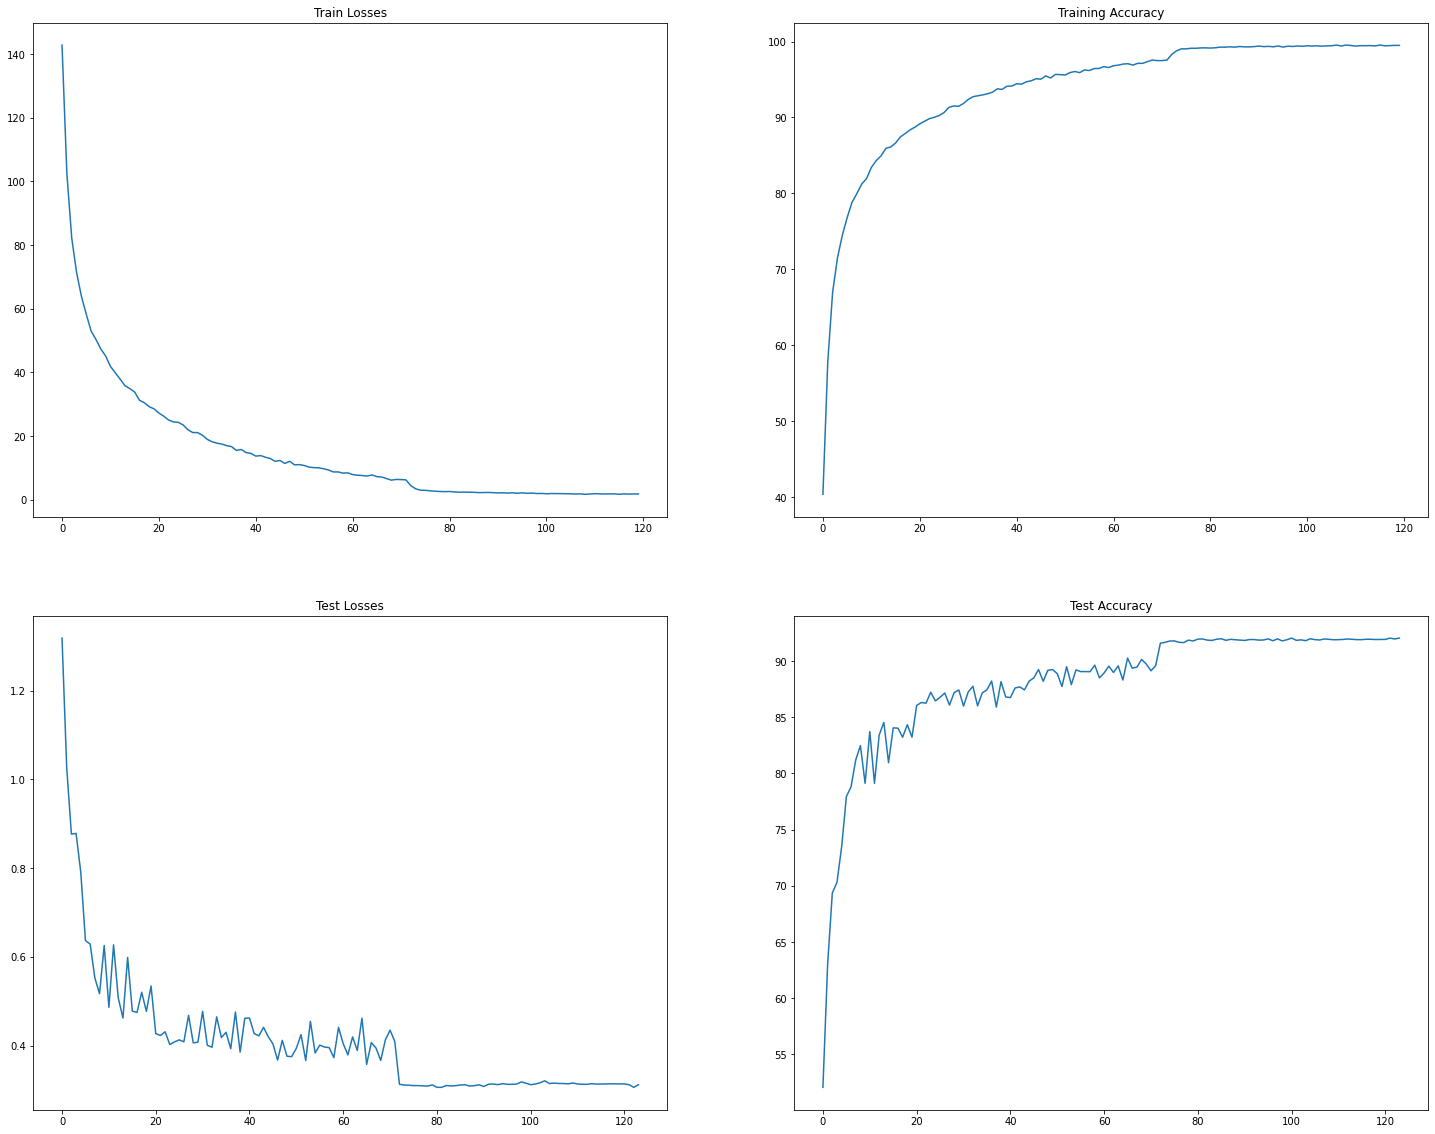

In [20]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)